In [2]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

from tensorflow.math import log, reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

!pip install patchify
from patchify import patchify

import matplotlib.patches as mpatches

In [50]:
data =r'C:\Users\Sumit\Semantic segmentation dataset'

patch_size = 256

In [51]:
image_dataset = []
for path, subdirs, files in os.walk(data):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [52]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [13]:
# !!! testing with small amount of patches

image_dataset = np.array(image_dataset[:400])
mask_dataset =  np.array(mask_dataset[:400])

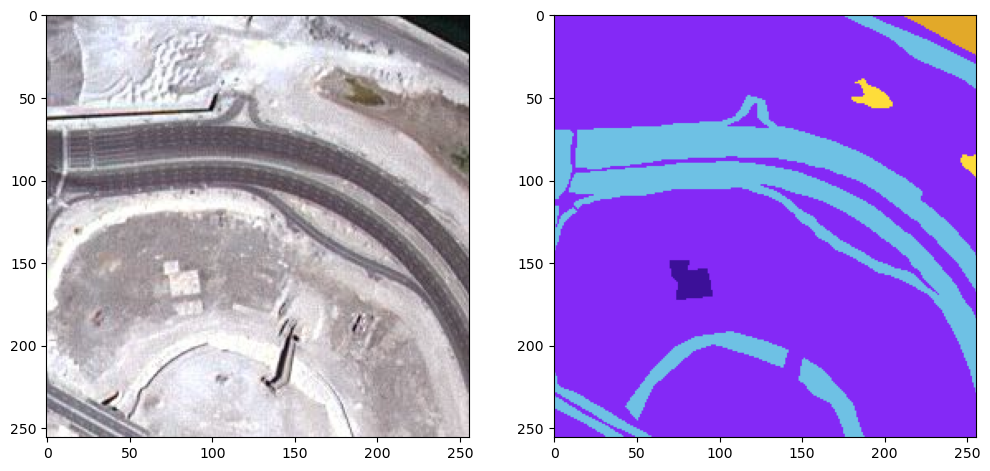

In [15]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [16]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [17]:
# !!! two class segmentation

label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 0
    label_seg [np.all(label == Road, axis = -1)] = 1  
    label_seg [np.all(label == Vegetation, axis = -1)] = 0   
    label_seg [np.all(label == Water, axis = -1)] = 0
    label_seg [np.all(label == Building, axis = -1)] = 2
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
labels = np.array(labels)

In [18]:
labels = np.array(labels)
labels.shape

(400, 256, 256)

In [19]:
labels_cat = to_categorical(labels)
labels_cat.shape

(400, 256, 256, 3)

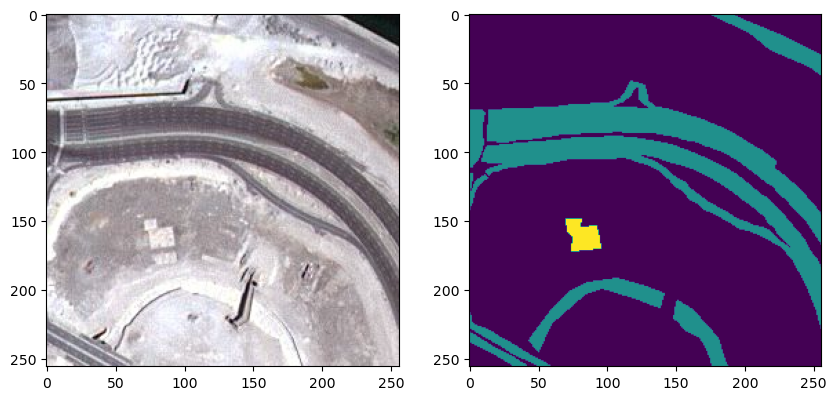

In [20]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number], vmin=0, vmax=2)
plt.show()


In [21]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [22]:
del image_dataset, mask_dataset, labels_cat, labels

In [23]:
def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(c5)
    
    #Expansive path 

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [24]:
n_classes =  y_train.shape[-1] - 1 # without Unlabeled . two class model
model = multi_unet_model(n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 2)  34          ['conv2d_13[0][0]']              
                                                                                                  
Total params: 1,031,170
Trainable params: 1,031,170
Non-trainable params: 0
__________________________________________________________________________________________________


In [25]:
def categorical_crossentropy_with_mask(y_true, y_pred):
    y_true = y_true[:,:,:,1:]
    loss_matrix = y_true * -log(y_pred)
    loss = reduce_mean(loss_matrix, axis=(1,2,3)) + 0.001
    return loss
                   
def accuracy_with_mask(y_true, y_pred):
    y_true = y_true[:,:,:,1:]
    N = y_pred.size
    accuracy = np.sum(y_true == y_pred)/ N

    return 1

In [77]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_mask,metrics='accuracy')

In [79]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1,
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/10
80/80 [==============================] - 145s 2s/step - loss: 0.0279 - accuracy: 0.5208 - val_loss: 0.0312 - val_accuracy: 0.5288
Epoch 2/10
80/80 [==============================] - 144s 2s/step - loss: 0.0248 - accuracy: 0.5130 - val_loss: 0.0273 - val_accuracy: 0.5282
Epoch 3/10
80/80 [==============================] - 146s 2s/step - loss: 0.0237 - accuracy: 0.5063 - val_loss: 0.0282 - val_accuracy: 0.5074
Epoch 4/10
80/80 [==============================] - 155s 2s/step - loss: 0.0231 - accuracy: 0.5084 - val_loss: 0.0282 - val_accuracy: 0.5123
Epoch 5/10
80/80 [==============================] - 166s 2s/step - loss: 0.0224 - accuracy: 0.5257 - val_loss: 0.0279 - val_accuracy: 0.5211
Epoch 6/10
80/80 [==============================] - 176s 2s/step - loss: 0.0216 - accuracy: 0.5196 - val_loss: 0.0265 - val_accuracy: 0.5315
Epoch 7/10
80/80 [==============================] - 166s 2s/step - loss: 0.0217 - accuracy: 0.5225 - val_loss: 0.0260 - val_accuracy: 0.5541
Epoch 8/10
80

1/1 [==============================] - 0s 440ms/step


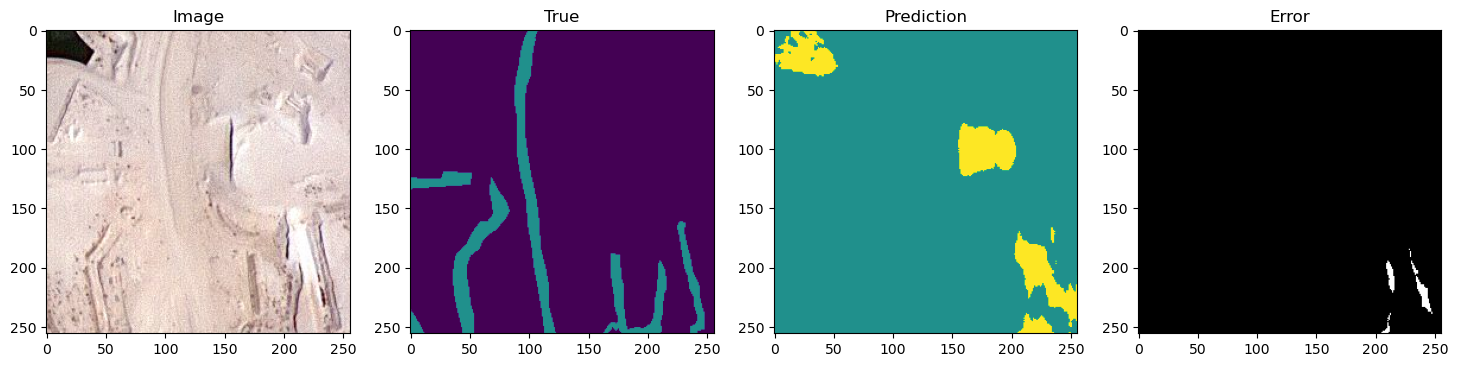

1/1 [==============================] - 0s 97ms/step


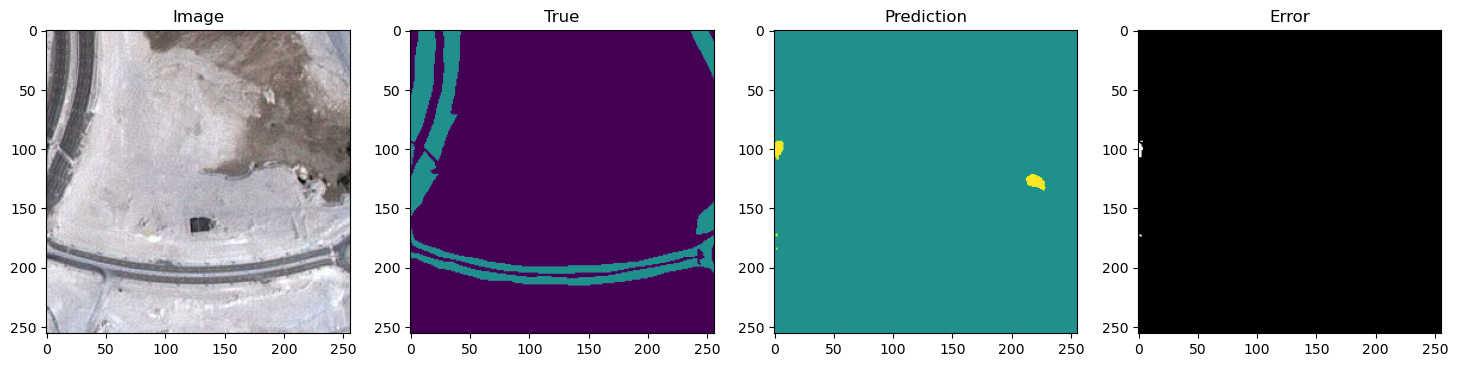

1/1 [==============================] - 0s 98ms/step


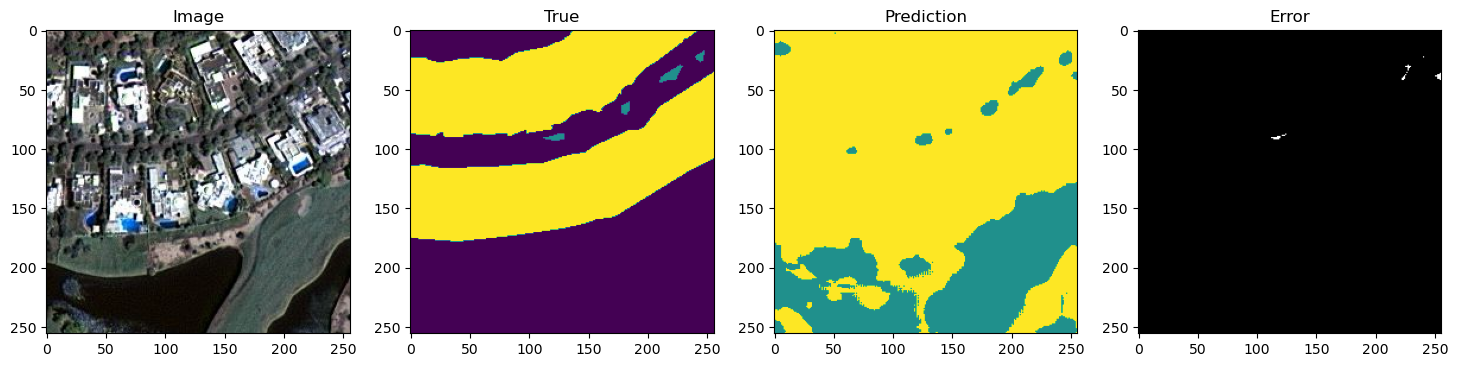

1/1 [==============================] - 0s 117ms/step


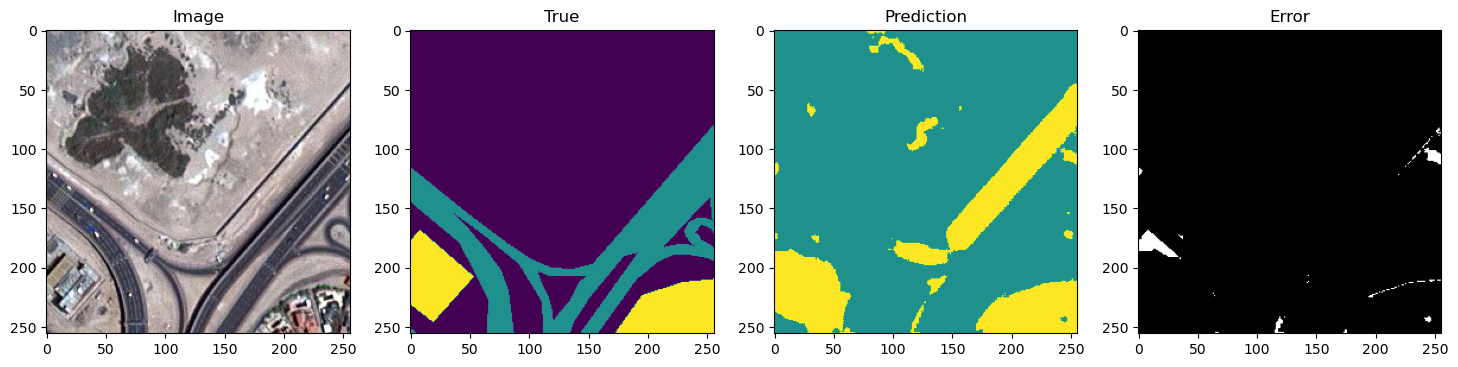

1/1 [==============================] - 0s 98ms/step


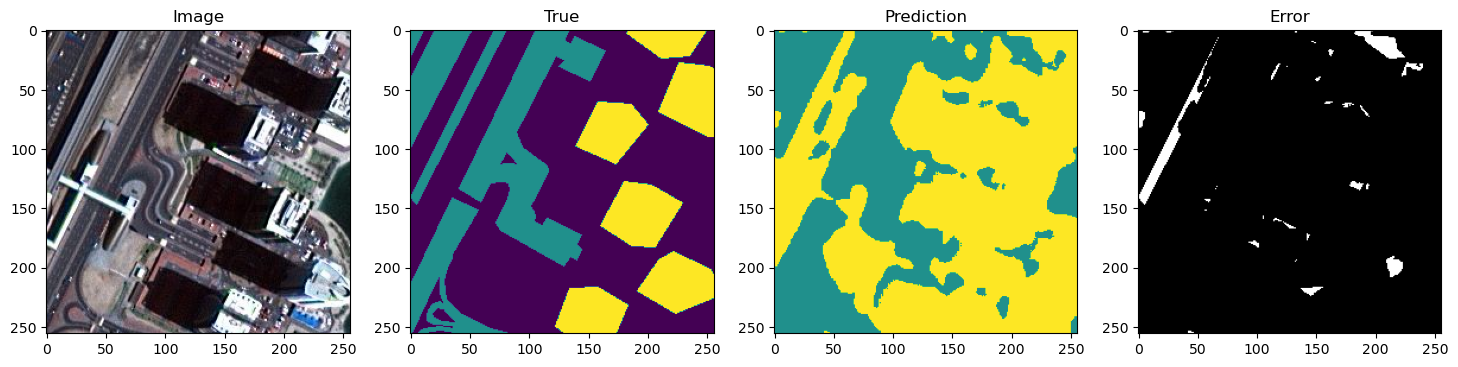

In [80]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(18, 8))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()

In [84]:
results = model.evaluate(X_test,  y_test, verbose = 0)


In [85]:
print('test loss, test acc:', results)


test loss, test acc: [0.02488216944038868, 0.581164538860321]


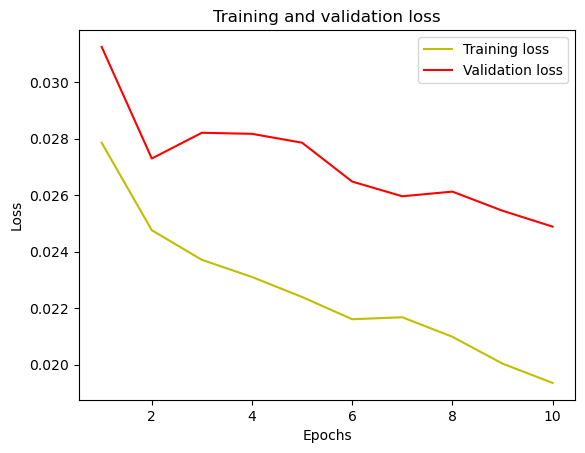

In [81]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

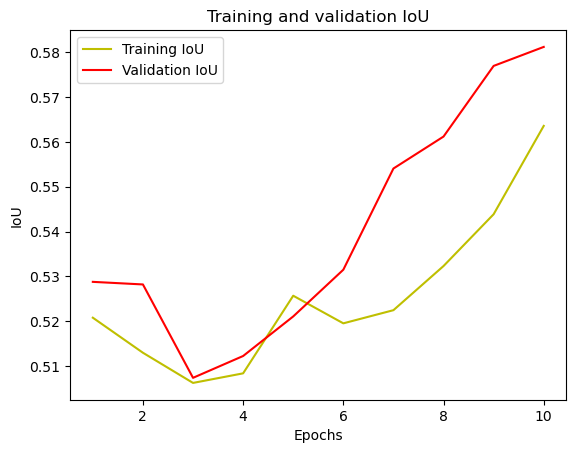

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [86]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

3/3 [==============================] - 6s 2s/step


In [87]:
#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.22274785


In [88]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 104ms/step


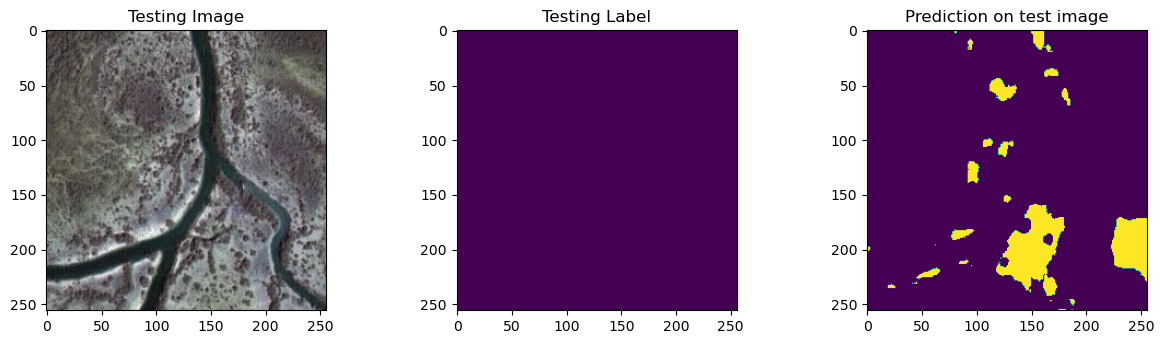

In [101]:
plt.figure(figsize=(15,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()